In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds

In [ ]:
tf.random.set_seed(
    1
)


In [ ]:
def load_model(model_path):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    return model

In [ ]:
def load_model(model_path):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
def load_model(model_path):

    img_inputs = tf.keras.Input(shape=(32, 32, 3))
    conv = Conv2D(64, kernel_size=(5, 5), strides = (2, 2))(tf.pad(img_inputs, ((0, 0), (3, 3), (3, 3), (0, 0))))
    norm = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.Activation("relu")(norm)
    mxpool = MaxPooling2D(pool_size=(2, 2))(act)
    conv1 = Conv2D(64, kernel_size=(5, 5),strides = (2, 2))(tf.pad(mxpool, ((0, 0), (3, 3), (3, 3), (0, 0))))
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    act1 = tf.keras.layers.Activation("relu")(norm1)
    mxpool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    conv2 = Conv2D(64, kernel_size=(5, 5),strides = (2, 2))(tf.pad(mxpool1, ((0, 0), (3, 3), (3, 3), (0, 0))))
    norm2 = tf.keras.layers.BatchNormalization()(conv2)
    act2 = tf.keras.layers.Activation("relu")(norm2)
    mxpool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    flatten = Flatten()(norm2)
    dense = Dense(2048)(flatten)
    norm3 = tf.keras.layers.BatchNormalization()(dense)
    dense1 = Dense(512)(norm3)
    norm4 = tf.keras.layers.BatchNormalization()(dense1)
    dense2 = Dense(10, activation='softmax')(norm4)
    model = tf.keras.Model(inputs=img_inputs, outputs=dense2, name="svhn_model")


    return model

In [ ]:
# Load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)

    random_indices = np.random.choice(len(trainX), 10016, replace=False)

    # Select the subset of data and labels
    subset_X = trainX[random_indices]
    subset_Y = trainY[random_indices]
    return subset_X, subset_Y, testX, testY

In [ ]:
# Load train and test dataset
def load_dataset():

    (train_image, train_label) = tfds.as_numpy(tfds.load('svhn_cropped', split='train',batch_size=-1 ,shuffle_files=True, as_supervised=True))
    (test_image, test_label) = tfds.as_numpy(tfds.load('svhn_cropped', split='test',batch_size=-1 ,shuffle_files=True, as_supervised=True))
    trainX = []
    trainY = []
    C = tf.constant(10, name = "C")
    one_hot_train = tf.one_hot(
    train_label, C, on_value = 1.0, off_value = 0.0, axis =-1)
    one_hot_test = tf.one_hot(
    test_label, C, on_value = 1.0, off_value = 0.0, axis =-1)
    for i in range(0,6):
      trainX.append(train_image[i * int(20000 / 6) : (i + 1) * int(20000 / 6)])
      trainY.append(one_hot_train[i * int(20000 / 6) : (i + 1) * int(20000 / 6)])

    return trainX, trainY, test_image, one_hot_test


In [ ]:
# scale pixels
def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

In [ ]:
trainX, trainY, testX, testY = load_dataset()



In [ ]:
def get_non_bn_weights(model):
  non_bn_weights = []
  for layer in model.layers:
    # Check if the layer is not a BatchNormalization layer
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        # Get the layer weights
        weights = layer.get_weights()
        # If the layer has weights, add them to the non_bn_weights list
        if len(weights) > 0:
            non_bn_weights.extend(weights)
  return non_bn_weights


In [ ]:
def set_non_bn_weights(model, new_weights):
    weight_index = 0

    # Iterate through the layers of the model
    for layer in model.layers:
        # Check if the layer is not a BatchNormalization layer
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            # Get the layer weights
            weights = layer.get_weights()
            # If the layer has weights, set them with the new weights from the list
            if len(weights) > 0:
                # Set the layer weights with the new weights from the list
                layer.set_weights([new_weights[weight_index], new_weights[weight_index + 1]])
                # Move to the next set of new weights and biases
                weight_index += 2


In [ ]:
def initializeC():
  model = load_model("")
  C = get_non_bn_weights(model)
  for i in C:
      i.fill(0)
  return C

In [ ]:
def initializeC():
  model = load_model("")
  C = model.get_weights()
  for i in C:
    i.fill(0)
  return C

In [ ]:
model = load_model("")
set_non_bn_weights(model,get_non_bn_weights(model))

In [ ]:
class ClientScaffold:
    def __init__(self, trainX, trainY, testX,
                 testY, batchSize, model,
                 loss, metrics, lr, optim=tf.keras.optimizers.legacy.SGD()):

        self.model = model
        self.c = self.initializeC()
        self.cPlus = self.initializeC()
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.batch = batchSize
        self.lr = float(lr)
        self.losses = loss
        self.metrics = metrics
        self.optim = optim
        self.optim.learning_rate = self.lr

    def train(self, C, Global):
        self.model.compile(optimizer=self.optim,
                           loss=self.losses, metrics=self.metrics)
        self.model.set_weights(Global)
        num_batches = len(self.trainX) // self.batch

        # Split the data into batches
        batches = np.array_split(self.trainX, self.batch)
        batchesY = np.array_split(self.trainY, self.batch)
        remaining_data = self.trainX[num_batches * self.batch:]
        if len(remaining_data) > 0:
            batches.append(remaining_data)
            batchesY.append(self.trainY[num_batches * self.batch:])

        for i in range(0, len(batches)):
            self.model.fit(
                batches[i], batchesY[i], verbose=0
            )
            weights = list(self.model.get_weights())
            for i in range(0, len(Global)):
                weights[i] += (1 / (len(batches) * self.lr)) * \
                    (C[i] - self.c[i])
            self.model.set_weights(weights)
        prit("Client",numpy.isnan(myarray).any(),"\n")
        weights = list(self.model.get_weights())
        delta_weights = list(weights)
        delta_C = list(self.cPlus)
        for i in range(0, len(weights)):
            self.cPlus[i] = self.c[i] - C[i] + (1 / ((1 / (len(batches) * self.lr))
                                                     * (len(self.trainX) / self.batch))) * (Global[i] - weights[i])
            delta_weights[i] -= Global[i]
            delta_C[i] = self.cPlus[i] - self.c[i]
        self.c = list(self.cPlus)

        return delta_weights, delta_C, len(self.trainX)

    def initializeC(self):
        C = self.model.get_weights()
        for i in C:
            i.fill(0)
        return C


In [ ]:
class Server:
  def __init__(self, global_lr, clients_num):
    self.C = initializeC()
    self.global_model = load_model(model_path = " ")
    self.global_model.compile(
    optimizer=tf.keras.optimizers.SGD(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )
    self.global_lr = global_lr
    self.clients_num = clients_num
  def initiate(self):
    self.clients = []
    optim = tf.keras.optimizers.legacy.SGD()
    for i in range(0,self.clients_num):
      self.clients.append(ClientScaffold(trainX[i], trainY[i], testX, testY, 32
                                         ,load_model("")
                                         ,tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                                         ,[tf.keras.metrics.CategoricalAccuracy()]
                                         , 0.01,optim))
  def train(self, rounds):
      weights = self.global_model.get_weights()
      c_temp = initializeC()
      for j in range(0,rounds):
        for client in self.clients:
             [delta_weights , delta_c , num_val] = client.train(self.C , self.global_model.get_weights())
             for i in range(0 , len(weights)):
                  weights[i] = weights[i] + (delta_weights[i] * (self.global_lr  /float(self.clients_num)))
                  c_temp[i] = c_temp[i] + delta_c[i] * (1.0 / self.clients_num)
        self.global_model.set_weights(weights)
        print("Global:",self.global_model.evaluate(testX, testY),"\n")


In [ ]:
server = Server(1, 6)

In [ ]:
server.initiate()

In [ ]:
server.train(10)

In [ ]:
categories = {'0' : [0,0,0,0,0,0],'1' : [0,0,0,0,0,0],'2' : [0,0,0,0,0,0],'3' :[0,0,0,0,0,0],'4' : [0,0,0,0,0,0],'5' : [0,0,0,0,0,0],'6' : [0,0,0,0,0,0],'7' : [0,0,0,0,0,0] ,'8' : [0,0,0,0,0,0],'9' : [0,0,0,0,0,0]}
for i in range (0,6):
  for j in trainY[i]:
    for k in range(0,10):
      if (j[k] == 1):
        categories[str(k)][i]  = categories[str(k)][i] + 1

In [ ]:
categories

{'0': [830, 812, 802, 813, 851, 840],
 '1': [2317, 2265, 2317, 2308, 2355, 2299],
 '2': [1698, 1721, 1798, 1759, 1800, 1809],
 '3': [1444, 1457, 1395, 1390, 1424, 1387],
 '4': [1288, 1285, 1247, 1220, 1206, 1212],
 '5': [1120, 1155, 1168, 1129, 1126, 1183],
 '6': [909, 948, 963, 983, 940, 984],
 '7': [953, 932, 926, 978, 912, 893],
 '8': [860, 861, 798, 826, 861, 838],
 '9': [790, 773, 795, 803, 734, 764]}

In [ ]:
actual = []
for i in range(0,10):
  actual.append(categories[str(i)])
actual =np.array(actual)


In [ ]:
import matplotlib.pyplot as plt

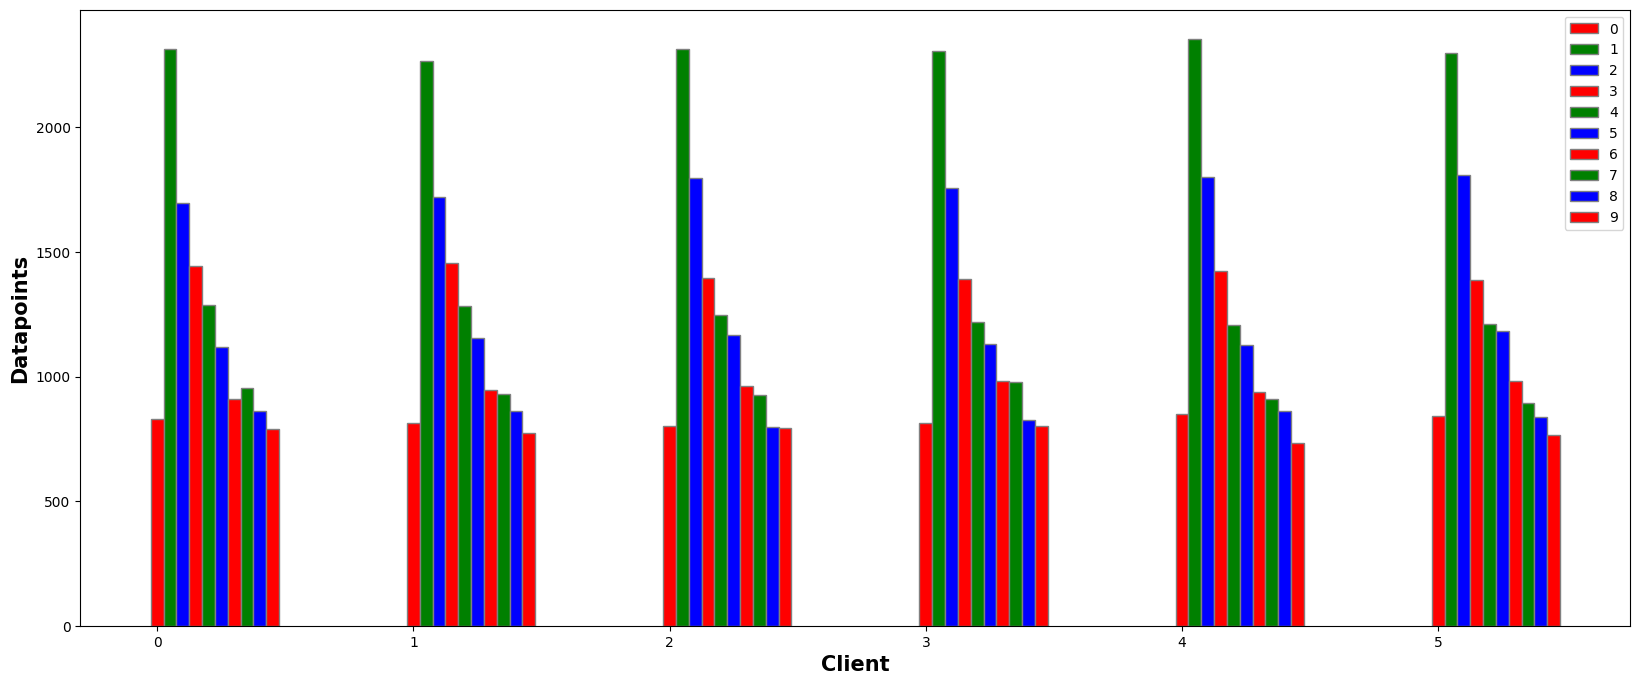

In [ ]:
barWidth = 0.05
fig = plt.subplots(figsize =(20, 8))


# Set position of bar on X axis
br1 = np.arange(len(actual[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]
br7 = [x + barWidth for x in br6]
br8 = [x + barWidth for x in br7]
br9 = [x + barWidth for x in br8]
br10 = [x + barWidth for x in br9]


# Make the plot
plt.bar(br1, actual[0], color ='r', width = barWidth,
        edgecolor ='grey', label ='0')
plt.bar(br2, actual[1], color ='g', width = barWidth,
        edgecolor ='grey', label ='1')
plt.bar(br3, actual[2], color ='b', width = barWidth,
        edgecolor ='grey', label ='2')
plt.bar(br4, actual[3], color ='r', width = barWidth,
        edgecolor ='grey', label ='3')
plt.bar(br5, actual[4], color ='g', width = barWidth,
        edgecolor ='grey', label ='4')
plt.bar(br6, actual[5], color ='b', width = barWidth,
        edgecolor ='grey', label ='5')
plt.bar(br7, actual[6], color ='r', width = barWidth,
        edgecolor ='grey', label ='6')
plt.bar(br8, actual[7], color ='g', width = barWidth,
        edgecolor ='grey', label ='7')
plt.bar(br9, actual[8], color ='b', width = barWidth,
        edgecolor ='grey', label ='8')
plt.bar(br10, actual[9], color ='r', width = barWidth,
        edgecolor ='grey', label ='9')

# Adding Xticks
plt.xlabel('Client', fontweight ='bold', fontsize = 15)
plt.ylabel('Datapoints', fontweight ='bold', fontsize = 15)


plt.legend()
plt.show()

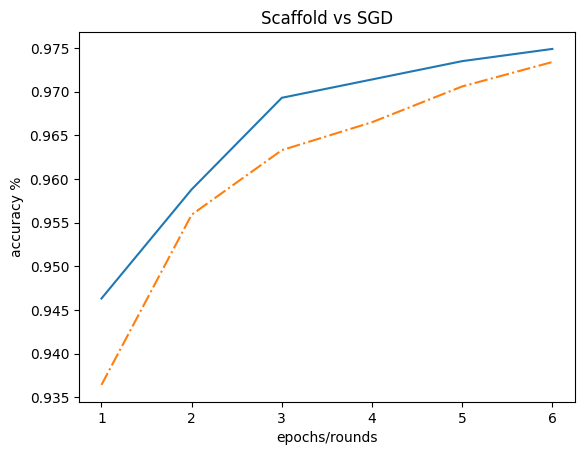

In [ ]:
scaffold_nreg = [0.9363999962806702,0.9559000134468079,0.9632999897003174,0.9664999842643738,0.9706000089645386,0.9733999967575073]
SGD = [0.9463,0.9588,0.9693,0.9714,0.9735,0.9749]
x = [i for i in range(1,7)]
plt.plot(x, SGD)
plt.plot(x, scaffold_nreg, '-.')
plt.xlabel("epochs/rounds")
plt.ylabel("accuracy %")
plt.title('Scaffold vs SGD')
plt.show()

In [ ]:
    #bare bones SGD with scaffold updates using gradient tape (Similar to pytorch)

    ##loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    ##optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    ##train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    ##val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    ##for i in range(0,len(self.trainX)):
    ## with tf.GradientTape() as tape:
    ##    logits = self.model(self.trainX[i], training=True)
    ##    loss_value = loss_fn(self.trainY[i], logits)
    ## grads = tape.gradient(loss_value, self.model.trainable_weights)
    ## for i in range (0 , len(Global)):
    ##    grads[i] += 1e-3 * (C[i] - self.c[i])
    ## optimizer.apply_gradients(zip(grads, self.model.trainable_weights))



        ##val_logits = self.model(self.testX, training=False)
        # Update val metrics
    ##val_acc_metric.update_state(self.testY, val_logits)
    ##val_acc = val_acc_metric.result()
    ##print("Client : Validation acc: %.4f" % (float(val_acc),))
    ##val_acc_metric.reset_states()
    ##results = self.model.evaluate(self.testX , self.testY, batch_size=128)

In [ ]:
# prompt: write import code for pytorch
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack= nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


In [ ]:
with torch.no_grad():
    for param in model.parameters():
        param.data = new_weights

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [ ]:
class ClientScaffold:
    def __init__(self, dataloader, batchSize, model,
                 loss, metrics, lr, optim):

        self.model = model
        self.c = self.initializeC()
        self.cPlus = self.initializeC()
        self.dataloader = dataloader
        self.batch = batchSize
        self.lr = float(lr)
        self.loss_fn = loss
        self.metrics = metrics
        self.optimizer = optim
        self.optimizer.learning_rate = self.lr



    def train_loop(self, C, Global):
      size = len(self.dataloader.dataset)#
      # Set the model to training mode - important for batch normalization and dropout layers
      self.model.train()#
      for batch, (X, y) in enumerate(self.dataloader):
        # Compute prediction and loss
        pred = self.model(X)
        loss = self.loss_fn(pred, y)#

        # Backpropagation
        self.loss.backward()#
        self.optimizer.step()#
        self.optimizer.zero_grad()#
        i = 0
        with torch.no_grad():
          for param in self.model.parameters():
              param.data = param.data + ((1 / (len(batches) * self.lr)) * \ #
                          (C[i] - self.c[i]))#
              i += 1
      weights = []
      with torch.no_grad():
          for param in self.model.parameters():
              weights.append(param.data)

      delta_weights = list(weights)
      delta_C = list(self.cPlus)#
      for i in range(0, len(weights)):
            self.cPlus[i] = self.c[i] - C[i] + (1 / ((1 / (len(batches) * self.lr))
                * (len(self.trainX) / self.batch))) * (Global[i] - weights[i])#
            delta_weights[i] -= Global[i]
            delta_C[i] = self.cPlus[i] - self.c[i]
      self.c = list(self.cPlus)
      return delta_weights, delta_C, size

     def initializeC(self):
        C = []
        with torch.no_grad():
          for param in self.model.parameters():
              C.append(param.data)
        for i in C:
            i.fill_(0)
        return C


In [ ]:
class ClientScaffold:
    def __init__(self, trainX, trainY, testX,
                 testY, batchSize, model,
                 loss, metrics, lr, optim=tf.keras.optimizers.legacy.SGD()):

        self.model = model
        self.c = self.initializeC()
        self.cPlus = self.initializeC()
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.batch = batchSize
        self.lr = float(lr)
        self.losses = loss
        self.metrics = metrics
        self.optim = optim
        self.optim.learning_rate = self.lr

    def train(self, C, Global):
        self.model.compile(optimizer=self.optim,
                           loss=self.losses, metrics=self.metrics)
        self.model.set_weights(Global)
        num_batches = len(self.trainX) // self.batch

        # Split the data into batches
        batches = np.array_split(self.trainX, self.batch)
        batchesY = np.array_split(self.trainY, self.batch)
        remaining_data = self.trainX[num_batches * self.batch:]
        if len(remaining_data) > 0:
            batches.append(remaining_data)
            batchesY.append(self.trainY[num_batches * self.batch:])

        for i in range(0, len(batches)):
            self.model.fit(
                batches[i], batchesY[i], verbose=0
            )
            weights = list(self.model.get_weights())
            for i in range(0, len(Global)):
                weights[i] += (1 / (len(batches) * self.lr)) * \
                    (C[i] - self.c[i])
            self.model.set_weights(weights)

        weights = list(self.model.get_weights())
        delta_weights = list(weights)
        delta_C = list(self.cPlus)
        for i in range(0, len(weights)):
            self.cPlus[i] = self.c[i] - C[i] + (1 / ((1 / (len(batches) * self.lr))
                                                     * (len(self.trainX) / self.batch))) * (Global[i] - weights[i])
            delta_weights[i] -= Global[i]
            delta_C[i] = self.cPlus[i] - self.c[i]
        self.c = list(self.cPlus)

        return delta_weights, delta_C, len(self.trainX)

    def initializeC(self):
        C = self.model.get_weights()
        for i in C:
            i.fill(0)
        return C

In [ ]:
814/814 [==============================] - 12s 14ms/step - loss: 1.8045 - categorical_accuracy: 0.4276
Global: [1.8045024871826172, 0.42755070328712463]

814/814 [==============================] - 12s 14ms/step - loss: 1.1670 - categorical_accuracy: 0.6280
Global: [1.1669645309448242, 0.6279578804969788]

814/814 [==============================] - 12s 14ms/step - loss: 0.7888 - categorical_accuracy: 0.7748
Global: [0.7887899279594421, 0.7748156189918518]

814/814 [==============================] - 12s 14ms/step - loss: 0.6863 - categorical_accuracy: 0.8100
Global: [0.6862868070602417, 0.809964656829834]

814/814 [==============================] - 12s 15ms/step - loss: 0.6541 - categorical_accuracy: 0.8232
Global: [0.6540713906288147, 0.8232175707817078]

814/814 [==============================] - 12s 15ms/step - loss: 0.6118 - categorical_accuracy: 0.8380
Global: [0.6118459105491638, 0.8380070924758911]

814/814 [==============================] - 12s 15ms/step - loss: 0.5958 - categorical_accuracy: 0.8445
Global: [0.5958079695701599, 0.844460666179657]

814/814 [==============================] - 12s 15ms/step - loss: 0.5773 - categorical_accuracy: 0.8509
Global: [0.5773475766181946, 0.8508758544921875]

814/814 [==============================] - 12s 14ms/step - loss: 0.5896 - categorical_accuracy: 0.8498
Global: [0.5895527005195618, 0.8497618436813354]

814/814 [==============================] - 12s 15ms/step - loss: 0.5688 - categorical_accuracy: 0.8578
Global: [0.5688490271568298, 0.8577520251274109]

